In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
chrom = "22"
model = "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True"

V = pl.read_parquet(f"../../results/positions/{chrom}/llr/{model}.subsample_10000000.annot.parquet")
V = V.with_columns(
    pl.col("consequence").str.replace("_variant", "")
)
V

chrom,pos,ref,alt,score,consequence
str,i64,str,str,f32,str
"""22""",10510068,"""A""","""G""",-1.703125,"""intergenic"""
"""22""",10510076,"""T""","""G""",-2.344482,"""intergenic"""
"""22""",10510080,"""A""","""T""",-2.135254,"""intergenic"""
"""22""",10510084,"""T""","""C""",1.03125,"""intergenic"""
"""22""",10510087,"""T""","""G""",-0.422363,"""intergenic"""
"""22""",10510093,"""C""","""T""",-0.027832,"""intergenic"""
"""22""",10510098,"""T""","""C""",-1.896484,"""intergenic"""
"""22""",10510100,"""C""","""A""",-1.763672,"""intergenic"""
"""22""",10510100,"""C""","""G""",-1.76123,"""intergenic"""


In [4]:
c_counts = V["consequence"].value_counts().sort("count", descending=True)
c_counts

consequence,count
str,u32
"""intron""",5275697
"""intergenic""",3446002
"""non_coding_tra…",443413
"""3_prime_UTR""",198938
"""upstream_gene""",183453
"""downstream_gen…",170413
"""missense""",140041
"""5_prime_UTR""",46155
"""synonymous""",42172


In [5]:
c_quantile = V.filter(
    pl.col("consequence").is_in(c_counts.filter(pl.col("count") >= 100)["consequence"])
).group_by("consequence").agg(pl.quantile("score", 0.01)).sort("score")
c_quantile

consequence,score
str,f32
"""stop_gained""",-13.257812
"""splice_accepto…",-13.082031
"""splice_donor""",-13.027344
"""splice_donor_5…",-13.003906
"""missense""",-12.601562
"""stop_lost""",-12.457031
"""start_lost""",-12.335938
"""splice_donor_r…",-11.150391
"""mature_miRNA""",-10.484375


In [6]:
c_plot = c_quantile["consequence"]
c_plot

consequence
str
"""stop_gained"""
"""splice_accepto…"
"""splice_donor"""
"""splice_donor_5…"
"""missense"""
"""stop_lost"""
"""start_lost"""
"""splice_donor_r…"
"""mature_miRNA"""


In [7]:
score_col = "GPN-MSA score"
df = V.filter(pl.col("consequence").is_in(c_plot)).to_pandas()
df["g"] = df.consequence
df[score_col] = df.score
df['consequence'] = pd.Categorical(df['consequence'], categories=c_plot, ordered=True)
df = df.sort_values("consequence")
df

,chrom,pos,ref,alt,score,consequence,g,GPN-MSA score
1592836,22,17689045,G,T,-12.027344,stop_gained,stop_gained,-12.027344
9926167,22,50519246,G,T,-2.718994,stop_gained,stop_gained,-2.718994
9926176,22,50519291,G,T,-6.714844,stop_gained,stop_gained,-6.714844
6043595,22,35323157,A,T,-11.466797,stop_gained,stop_gained,-11.466797
9926182,22,50519318,C,T,-5.077881,stop_gained,stop_gained,-5.077881
...,...,...,...,...,...,...,...,...
3680017,22,26067410,A,G,-0.878906,intergenic,intergenic,-0.878906
3680016,22,26067408,C,A,-1.500000,intergenic,intergenic,-1.500000
3680015,22,26067400,C,A,-1.522461,intergenic,intergenic,-1.522461
3680033,22,26067454,G,T,-0.994629,intergenic,intergenic,-0.994629


In [12]:
q = 1 / 10_000 #1/2_000
x_left, x_right = df[score_col].quantile(q), df[score_col].quantile(1-q)
x_left, x_right

(-12.896484375, 5.2102073242185725)

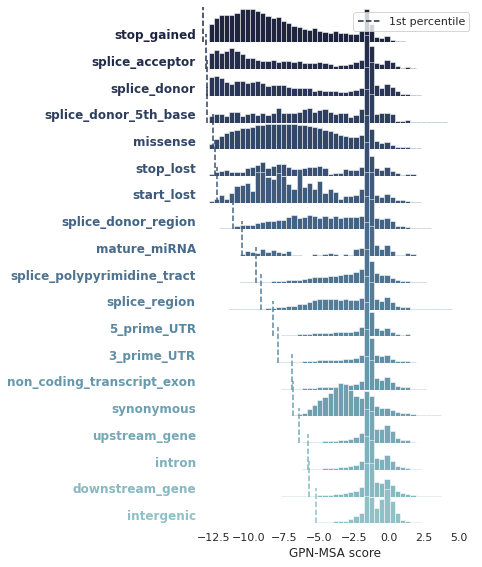

In [14]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

pal = sns.cubehelix_palette(len(c_plot), rot=-.25, light=.7, reverse=True)
g = sns.FacetGrid(
    df, row="g", hue="g",
    aspect=10,#15,
    #height=.5,  # doesn't work
    #height=1, # this works
    height=0.5,
    palette=pal,
    sharey=False,
)

g.map(
    sns.histplot,
    score_col,
    bins=np.linspace(x_left, x_right, 50),
    alpha=1,
    fill=True,
    stat="density",
)

def label(x, color, label):
    ax = plt.gca()
    ax.text(
        0, .2, label, fontweight="bold", color=color,
        ha="right",
        va="center", transform=ax.transAxes
    )
g.map(label, score_col)

def add_quantile(x, color, label):
    ax = plt.gca()
    artist = ax.axvline(x.quantile(0.01), ls='--', color=color)
    
g.map(add_quantile, score_col)

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True);
import matplotlib

artist = [c for c in g.axes[0,0].get_children() if type(c)==matplotlib.lines.Line2D][0]
legend = g.axes[0,0].legend([artist], ["1st percentile"], loc="upper right")
legend.get_frame().set_facecolor('white')
#plt.savefig("../../results/plots/ism.pdf", bbox_inches="tight")

In [11]:
V.sort("score", descending=True).head(10)

chrom,pos,ref,alt,score,consequence
str,i64,str,str,f32,str
"""22""",25459429,"""T""","""C""",9.556641,"""non_coding_tra…"
"""22""",41387550,"""C""","""G""",9.472656,"""missense"""
"""22""",30932707,"""A""","""G""",9.416016,"""missense"""
"""22""",23963924,"""G""","""T""",9.324219,"""splice_donor_r…"
"""22""",41147882,"""T""","""G""",9.322266,"""missense"""
"""22""",19766568,"""A""","""C""",9.28418,"""missense"""
"""22""",21065539,"""T""","""A""",9.064453,"""non_coding_tra…"
"""22""",37095596,"""A""","""T""",8.8984375,"""splice_polypyr…"
"""22""",28351522,"""T""","""A""",8.564453,"""intron"""
